# Intensity Smoothing
The network intensities quite noisy to work with, especially the further away ones. Can we smoothen them out?

## Which Data to Work With?
Previously, I was adding up the data from all photons. This data is stored in _/data/intensity/test.pkl_. However, the alternate would be to find the mean of all photons. The means are store in _/data/intensity/intensity_averaged_sim_data.pkl_.  

To generate a new set of data, edit & run this _/tools/intensity_data_generator.py_

In this notebook, you can select either one and see how it fits under different fitting functions.

In [1]:
# import simulation data
import seaborn as sns
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import _generate_weights_log
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import pandas as pd

# Load Data
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/test_data.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_averaged_sim_data.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_summed_sim_data_equidistance_detector_extended.pkl')
equidistance_detector_normalization(data)
data.head(10)

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a
0,10,1.812894e-04,2.0,5.0,26.0,0.005,0.05
1,14,3.681103e-05,2.0,5.0,26.0,0.005,0.05
2,19,8.854552e-06,2.0,5.0,26.0,0.005,0.05
3,23,2.952029e-06,2.0,5.0,26.0,0.005,0.05
4,28,1.092797e-06,2.0,5.0,26.0,0.005,0.05
5,32,4.277922e-07,2.0,5.0,26.0,0.005,0.05
6,37,1.715046e-07,2.0,5.0,26.0,0.005,0.05
7,41,7.471047e-08,2.0,5.0,26.0,0.005,0.05
8,46,3.120305e-08,2.0,5.0,26.0,0.005,0.05
9,50,1.365238e-08,2.0,5.0,26.0,0.005,0.05


In [2]:
parameter_names = ['Maternal Mu_a', 'Fetal Mu_a', 'Maternal Wall Thickness', 'Uterus Thickness']
for parameter in parameter_names:
    print(parameter, ' unique values ', pd.unique(data[parameter]))

Maternal Mu_a  unique values  [0.005 0.009 0.013 0.017 0.021 0.025 0.029 0.033 0.037 0.041 0.045 0.049]
Fetal Mu_a  unique values  [0.05 0.09 0.13 0.17 0.21 0.25 0.29]
Maternal Wall Thickness  unique values  [26. 30. 14.  6. 12. 36. 20. 10. 38. 28.  2. 22. 18. 24. 16.  4.  8. 34.
 32.]
Uterus Thickness  unique values  [5.]


In [3]:
plt.rcParams["font.size"] = 18

In [4]:
test_sample = data[(data['Wave Int'] == 2.0) & (data['Uterus Thickness'] == 5.0) & (data['Maternal Mu_a'] == 0.005) & (data['Fetal Mu_a'] == 0.05) & (data['Maternal Wall Thickness'] == 10.0)]
print(f"Picking a sample with length : {test_sample.shape}")

Picking a sample with length : (20, 7)


## Fit Using Exponentials
Assume the data should fit some function of the form $y = Ae^{-b \times x}$. Taking ln on bothsides, $ln(y) = ln(A) - b \times x$. Where, x is the intensity SDD and y is the resulting intensity.

In [5]:
x = np.ones((len(test_sample), 2))  # One column for SDD and one for the bias
x[:, 0] = test_sample['SDD'].to_numpy()

Y = np.log(test_sample['Intensity'].to_numpy()).reshape(-1, 1)

In [6]:
beta_hat = np.linalg.inv(x.T @ x) @ x.T @ Y
y_hat = x @ beta_hat

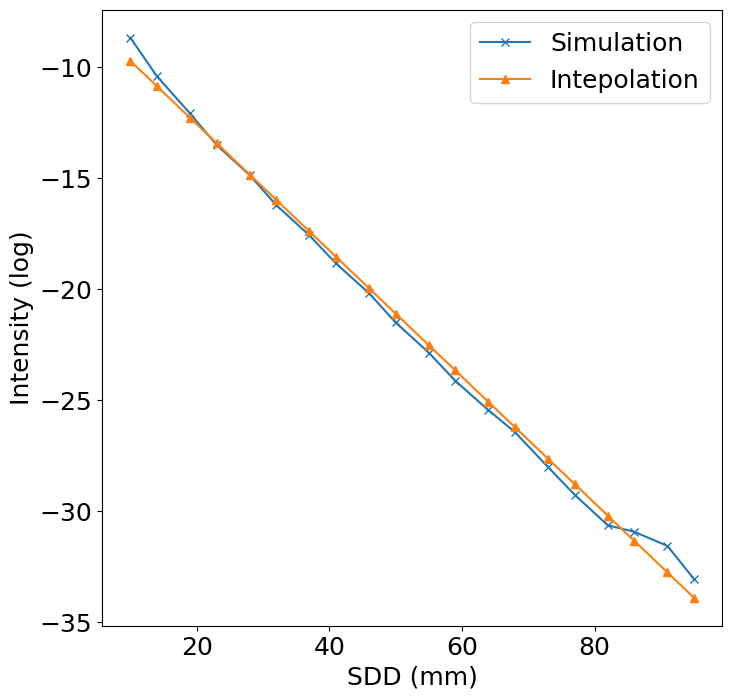

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(test_sample['SDD'].to_numpy(), np.log(test_sample['Intensity'].to_numpy()), label="Simulation", marker='x')
plt.plot(test_sample['SDD'].to_numpy(), y_hat, label="Intepolation", marker='^')
plt.xlabel("SDD (mm)")
plt.ylabel("Intensity (log)")
plt.legend()

# Fit Using Weighted Exponentials
We put larger weight on the close detectors and then use linnear regeression. So optimization equation has the form of $argmin_{\beta} \sum_{i=1}^{20} w_i ||y_i - \sum_{j=1}^2 x_{ij}\beta_j||^2_2$. The solution is of the form $$\hat\beta = (X^TWX)^{-1}X^TWy$$. Where W is a diagonal matrix with the corresponding weights

In [8]:
x = np.ones((len(test_sample), 2))  # One column for SDD and one for the bias
x[:, 0] = test_sample['SDD'].to_numpy()

Y = np.log(test_sample['Intensity'].to_numpy()).reshape(-1, 1)

In [9]:
W = np.diag(np.linspace(1, 0.001, num=20))   # Define the weight

In [10]:
beta_hat = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ Y # Solve
y_hat = x @ beta_hat

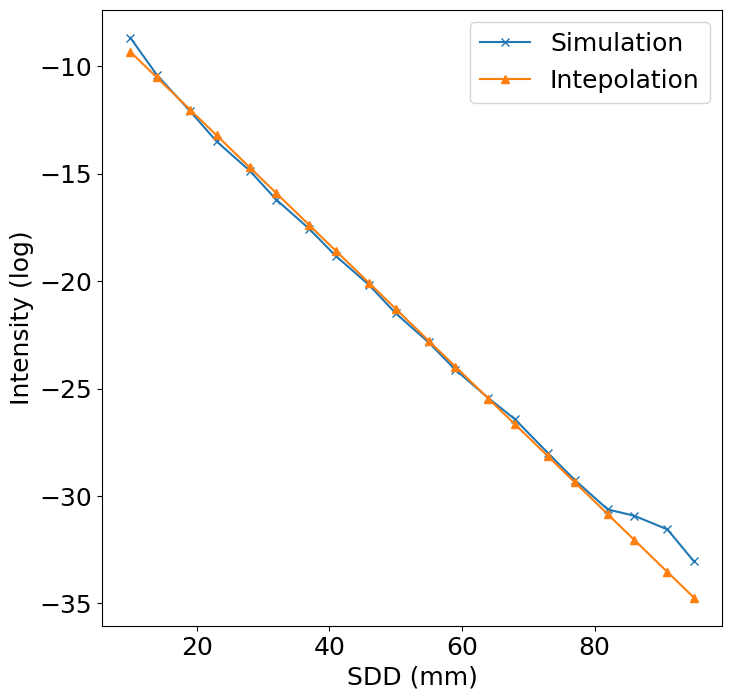

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(test_sample['SDD'].to_numpy(), np.log(test_sample['Intensity'].to_numpy()), label="Simulation", marker='x')
plt.plot(test_sample['SDD'].to_numpy(), y_hat, label="Intepolation", marker='^')
plt.xlabel("SDD (mm)")
plt.ylabel("Intensity (log)")
plt.legend()

Without any numeric proof, just eyeballing, the weighted one seems to fit to fit the nearer points better. Whereas, the non-weighted one messes up some of the closer points.

The issue with linear weights is that for the near detectors, the actual predicted vlues(non-log) were 2x or 3x off. That is a massive difference. But in logscale, these differences are very small. Which leads us to the next method

# Fit Using Logarithmically Weighted Exponentials
Same concept as before, except the weights are now logarithmically distributed. Meaning near detectors get much higher importance than the far away ones.

## Test 1 : Smaller Range

    SDD     Simualted  Interpolated
0    10  1.607362e-04  1.469730e-04
1    14  2.545825e-05  2.933890e-05
2    19  4.041090e-06  4.171664e-06
3    23  8.215231e-07  9.219086e-07
4    28  1.754654e-07  1.488568e-07
5    32  3.853275e-08  3.641829e-08
6    37  8.210757e-09  6.677527e-09
7    41  1.899124e-09  1.808584e-09
8    46  4.409541e-10  3.765740e-10
9    50  1.048796e-10  1.129134e-10
10   55  2.254981e-11  2.669762e-11
11   59  5.710508e-12  8.862172e-12
12   64  1.875591e-12  2.379482e-12
13   68  5.860725e-13  8.744245e-13
14   73  2.119328e-13  2.666121e-13
BETA_HAT : [[-4.36737149e-01]
 [ 1.41264493e-03]
 [-4.59915448e+00]]


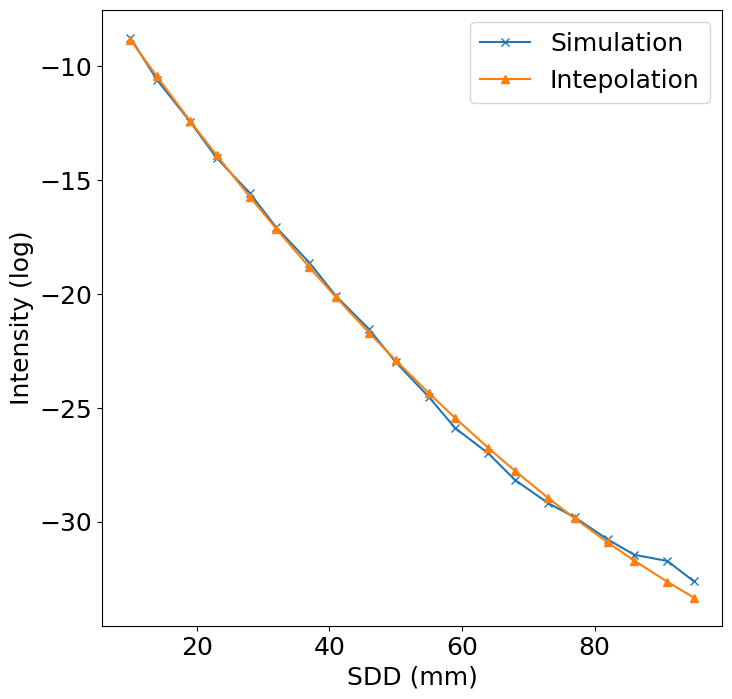

In [12]:
test_sample = data[(data['Wave Int'] == 2.0) & (data['Uterus Thickness'] == 5.0) & (data['Maternal Mu_a'] == 0.005) & (data['Fetal Mu_a'] == 0.05) & (data['Maternal Wall Thickness'] == 8.0)]

x = np.ones((len(test_sample), 3))  # One column for SDD and one for the bias
x[:, 0] = test_sample['SDD'].to_numpy()
x[:, 1] = np.square(test_sample['SDD'].to_numpy())
Y = np.log(test_sample['Intensity'].to_numpy()).reshape(-1, 1)
# W = np.diag(np.linspace(1, 0.05, num=20))   # Define the weight
W = np.diag(np.logspace(1, -2, num=20))   # Define the weight
beta_hat = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ Y # Solve
y_hat = x @ beta_hat

compare = DataFrame({"SDD" : test_sample['SDD'].to_numpy(), "Simualted" : test_sample['Intensity'].to_numpy(), "Interpolated" : np.exp(y_hat).flatten()})
print(compare.head(15))

print(f"BETA_HAT : {beta_hat}")
plt.figure(figsize=(8, 8))
plt.plot(test_sample['SDD'].to_numpy(), np.log(test_sample['Intensity'].to_numpy()), label="Simulation", marker='x')
plt.plot(test_sample['SDD'].to_numpy(), y_hat, label="Intepolation", marker='^')
plt.xlabel("SDD (mm)")
plt.ylabel("Intensity (log)")
plt.legend()

## Test 2 : Larger Range

    SDD     Simualted  Interpolated
0    10  1.607362e-04  1.584228e-04
1    14  2.545825e-05  2.763159e-05
2    19  4.041090e-06  3.639768e-06
3    23  8.215231e-07  8.146178e-07
4    28  1.754654e-07  1.465503e-07
5    32  3.853275e-08  4.208807e-08
6    37  8.210757e-09  1.034087e-08
7    41  1.899124e-09  3.810845e-09
8    46  4.409541e-10  1.278746e-09
9    50  1.048796e-10  6.047011e-10
10   55  2.254981e-11  2.771206e-10
11   59  5.710508e-12  1.681579e-10
12   64  1.875591e-12  1.052472e-10
13   68  5.860725e-13  8.195039e-11
14   73  2.119328e-13  7.005018e-11
BETA_HAT : [[-5.19694163e-01]
 [ 3.46321784e-03]
 [-3.89962325e+00]]


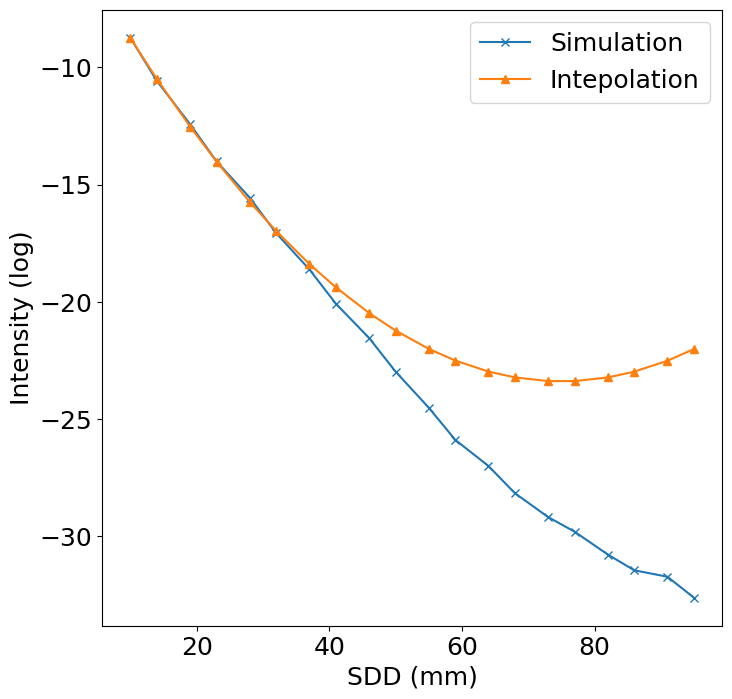

In [13]:
test_sample = data[(data['Wave Int'] == 2.0) & (data['Uterus Thickness'] == 5.0) & (data['Maternal Mu_a'] == 0.005) & (data['Fetal Mu_a'] == 0.05) & (data['Maternal Wall Thickness'] == 8.0)]

x = np.ones((len(test_sample), 3))  # One column for SDD and one for the bias
x[:, 0] = test_sample['SDD'].to_numpy()
x[:, 1] = np.square(test_sample['SDD'].to_numpy())
Y = np.log(test_sample['Intensity'].to_numpy()).reshape(-1, 1)
# W = np.diag(np.linspace(1, 0.05, num=20))   # Define the weight
W = np.diag(np.logspace(1, -8, num=20))   # Define the weight
beta_hat = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ Y # Solve
y_hat = x @ beta_hat

compare = DataFrame({"SDD" : test_sample['SDD'].to_numpy(), "Simualted" : test_sample['Intensity'].to_numpy(), "Interpolated" : np.exp(y_hat).flatten()})
print(compare.head(15))
print(f"BETA_HAT : {beta_hat}")
plt.figure(figsize=(8, 8))
plt.plot(test_sample['SDD'].to_numpy(), np.log(test_sample['Intensity'].to_numpy()), label="Simulation", marker='x')
plt.plot(test_sample['SDD'].to_numpy(), y_hat, label="Intepolation", marker='^')
plt.xlabel("SDD (mm)")
plt.ylabel("Intensity (log)")
plt.legend()

It overfits for the closer values but steers way off-course for larger range (i.e, completely disregarding smaller values.) But smaller values seem to give a better performace

The weights are essentially the inverse of the expected variance. If we can somehow determine the expected variance in the data, we can better approximate what the weights should theoretically be.

# Exponentially Weighted Logarithmic Fit With SDD and SQRT(SDD)
Instead of using a single feature (+ bias), we turn to using sqrt of SDD, and SDD (+ bias). This gave better results for me in the EMB paper. (Well without the weighting part)

    SDD     Simualted  Interpolated
0    10  1.813882e-04  1.683490e-04
1    14  3.688627e-05  4.132647e-05
2    19  8.901377e-06  9.341085e-06
3    23  2.986326e-06  3.278910e-06
4    28  1.117056e-06  1.005659e-06
5    32  4.442585e-07  4.225031e-07
6    37  1.820206e-07  1.543887e-07
7    41  8.148482e-08  7.261874e-08
8    46  3.525521e-08  2.983704e-08
9    50  1.604253e-08  1.519390e-08
10   55  7.412810e-09  6.800321e-09
11   59  3.393385e-09  3.676060e-09
12   64  1.629040e-09  1.757489e-09
13   68  8.019514e-10  9.958051e-10
14   73  3.699042e-10  5.019365e-10
BETA_HAT : [[ 0.01251081]
 [-2.51058067]
 [-0.87542611]]


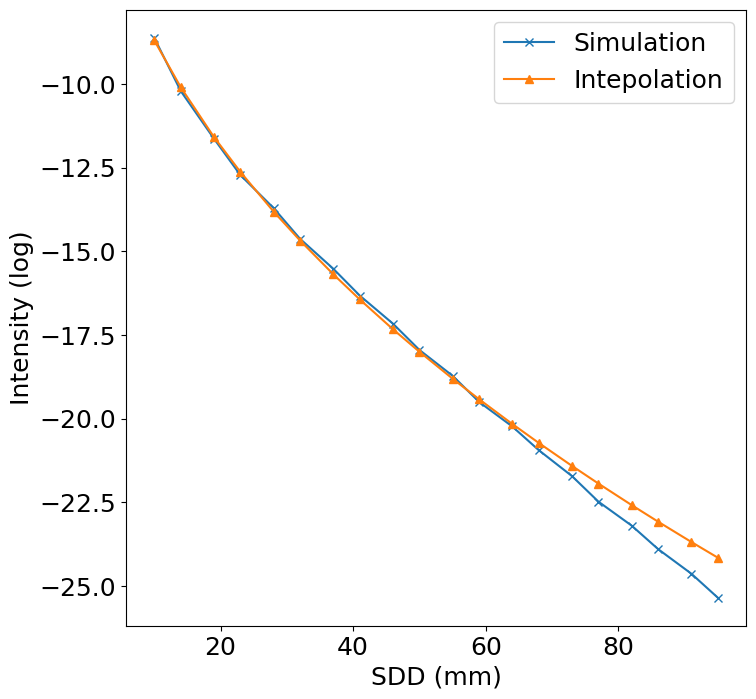

In [14]:
test_sample = data[(data['Wave Int'] == 2.0) & (data['Uterus Thickness'] == 5.0) & (data['Maternal Mu_a'] == 0.005) & (data['Fetal Mu_a'] == 0.13) & (data['Maternal Wall Thickness'] == 36.0)]

x = np.ones((len(test_sample), 3))  # One column for SDD and one for the bias
x[:, 0] = test_sample['SDD'].to_numpy()
x[:, 1] = np.sqrt(test_sample['SDD'].to_numpy())
Y = np.log(test_sample['Intensity'].to_numpy()).reshape(-1, 1)
# W = np.diag(np.linspace(1, 0.05, num=20))   # Define the weight
W = np.diag(np.logspace(1, -2, num=20))   # Define the weight
beta_hat = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ Y # Solve
y_hat = x @ beta_hat

compare = DataFrame({"SDD" : test_sample['SDD'].to_numpy(), "Simualted" : test_sample['Intensity'].to_numpy(), "Interpolated" : np.exp(y_hat).flatten()})
print(compare.head(15))

print(f"BETA_HAT : {beta_hat}")
plt.figure(figsize=(8, 8))
plt.plot(test_sample['SDD'].to_numpy(), np.log(test_sample['Intensity'].to_numpy()), label="Simulation", marker='x')
plt.plot(test_sample['SDD'].to_numpy(), y_hat, label="Intepolation", marker='^')
plt.xlabel("SDD (mm)")
plt.ylabel("Intensity (log)")
plt.legend()

# Test Space
Test out different prediction parameters here!

In [15]:
parameter_names = ['Maternal Mu_a', 'Fetal Mu_a', 'Maternal Wall Thickness', 'Uterus Thickness']
for parameter in parameter_names:
    print(parameter, ' unique values ', pd.unique(data[parameter]))

Maternal Mu_a  unique values  [0.005 0.009 0.013 0.017 0.021 0.025 0.029 0.033 0.037 0.041 0.045 0.049]
Fetal Mu_a  unique values  [0.05 0.09 0.13 0.17 0.21 0.25 0.29]
Maternal Wall Thickness  unique values  [26. 30. 14.  6. 12. 36. 20. 10. 38. 28.  2. 22. 18. 24. 16.  4.  8. 34.
 32.]
Uterus Thickness  unique values  [5.]


     SDD     Simualted  Interpolated
0    0.0  1.000000e+00  1.000000e+00
1   10.0  1.700349e-04  1.793270e-04
2   14.0  3.236585e-05  4.009766e-05
3   19.0  7.069639e-06  7.757359e-06
4   23.0  2.083197e-06  2.347239e-06
5   28.0  6.631096e-07  5.839551e-07
6   32.0  2.183625e-07  2.042795e-07
7   37.0  7.194087e-08  5.840679e-08
8   41.0  2.557151e-08  2.232198e-08
9   46.0  8.530343e-09  6.988640e-09
10  50.0  2.989650e-09  2.838421e-09
11  55.0  1.059371e-09  9.482836e-10
12  59.0  3.737727e-10  4.028535e-10
13  64.0  1.363312e-10  1.413875e-10
14  68.0  5.393881e-11  6.219766e-11
BETA_HAT : [[-4.40669679]
 [-3.60090986]
 [-4.47769324]]


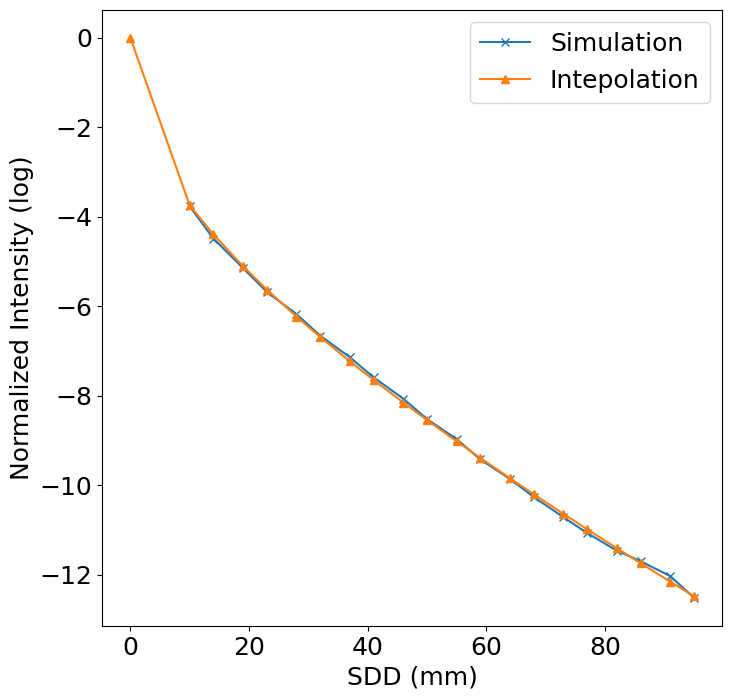

In [22]:
test_sample = data[(data['Wave Int'] == 1.0) & (data['Uterus Thickness'] == 5.0) & (data['Maternal Mu_a'] == 0.005) & (data['Fetal Mu_a'] == 0.29) & (data['Maternal Wall Thickness'] == 12.0)]

input_sdd = test_sample['SDD'].to_numpy()
input_sdd = np.append([0.0], input_sdd)

input_y = test_sample['Intensity'].to_numpy()
input_y = np.append([1], input_y)

x = np.ones((len(input_sdd), 3))  # One column for SDD and one for the bias
x[:, 0] = input_sdd
x[:, 1] = np.sqrt(input_sdd)
x[:, 2] = np.power(input_sdd, 1/3)
Y = np.log10(input_y).reshape(-1, 1)

# Normalize By Max
x[:, :] /= np.max(x[:, :], axis=0)
# Normalize to be between 0 and -1
Y_MULTIPLIER = 1
Y /= Y_MULTIPLIER


# W = np.diag(np.linspace(1, 0.05, num=20))   # Define the weight
# W = np.diag(np.logspace(1, -3, num=20))   # Define the weight
W = np.diag(_generate_weights_log((0, 1), (x[0, 0], x[-1, 0]), x[:, 0]))
beta_hat = np.linalg.inv(x.T @ W @ x) @ x.T @ W @ Y # Solve
y_hat = x @ beta_hat * Y_MULTIPLIER

compare = DataFrame({"SDD" : input_sdd, "Simualted" : input_y, "Interpolated" : np.power(10, y_hat).flatten()})
print(compare.head(15))

print(f"BETA_HAT : {beta_hat}")
plt.figure(figsize=(8, 8))
plt.plot(test_sample['SDD'].to_numpy(), np.log10(test_sample['Intensity'].to_numpy()), label="Simulation", marker='x')
plt.plot(input_sdd, y_hat, label="Intepolation", marker='^')
plt.xlabel("SDD (mm)")
plt.ylabel("Normalized Intensity (log)")
plt.legend()

# Error
Calculate the weighted error due to fitting a curve on the simulation data.

In [17]:
# Define fitting function
from typing import Tuple
def custom_interpolation_func(data: DataFrame, weights: Tuple[float, float]) -> np.array:
    X = np.ones((len(data), 4))  # One column for SDD and one for the bias
    X[:, 0] = data['SDD'].to_numpy()
    X[:, 1] = np.sqrt(data['SDD'].to_numpy())
    X[:, 2] = np.power(data['SDD'].to_numpy(), 1/3)
    # TODO : Figure out the best interpolation
    Y = np.log(data['Intensity'].to_numpy()).reshape(-1, 1)
    # Define the weight
    W = np.diag(np.logspace(weights[0], weights[1], num=len(Y)))
    beta_hat = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ Y  # Solve
    y_hat = X @ beta_hat
    y_hat = np.exp(y_hat)
    mse_error = np.square(Y - y_hat) * np.logspace(weights[0], weights[1], num=len(Y))
    return np.exp(y_hat), mse_error


In [18]:
sdd_chunk_size = 20
weights = [1, -3]
interpolated_intensity = None
error_column = None
for i in range(len(data)//sdd_chunk_size):
    data_chunk = data.iloc[sdd_chunk_size*i: sdd_chunk_size * (i + 1), :]
    y_hat, error = custom_interpolation_func(data_chunk, weights)
    if interpolated_intensity is None:
        interpolated_intensity = y_hat
        error_column = error
    else:
        interpolated_intensity = np.vstack([interpolated_intensity, y_hat])
        error_column = np.vstack([error_column, error])
data['Interpolated Intensity'] = interpolated_intensity
data['Weighted MSE Error'] = error_column

ValueError: Expected a 1D array, got an array with shape (63840, 20)